In [ ]:
# In this jupyter notebook, we will check the responses collected online for completeness. 
# Also, we will perform some basic sanity checks.
# We will first load the data from a json file and transform it into a pandas data frame. 
# Next, we will make sure to reformat that data frame such that every row is one trial (the json file will give us
# one row for every event)

### Inclusion Criteria 
1. completeness:

every participant has done the same number of trials

2. screen requirements

height and width support full stimulus presentation

3. responses in survey

participants responded with the index finger

concentration rating at least neutral

fullscreen worked

no comments about missunderstanding etc.

4. data quality

for jump trials: error on jumped trials gets smaller with shorter SOAs (response adjusted to jump)

for serial trials: touch position better explained by true location than by mean (response targeted dots)

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Define a custom color map
top = plt.cm.get_cmap('Greens_r', 128)
bottom = plt.cm.get_cmap('Greys', 128)

shiftcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
shiftcmp = cls.ListedColormap(shiftcolors, name='GnGy')

In [2]:
data = {}
# load data from different components:

# the experimental component
exp_data =  open('../data/jatos_results_04_08.txt')
# unpack the data
for ses, jf in enumerate(exp_data):
    
    # save it to a data frame
    jd = json.loads(jf)
    df = pd.DataFrame(jd)
    df['session'] = ses

    try:
        data = pd.concat([data,df], axis = 0)
        #print('fail')
    except:
        data = df
data.reset_index(drop = True, inplace = True)
data

,view_history,rt,test_part,trial_type,trial_index,time_elapsed,internal_node_id,subject,screenWidth,screenHeight,...,touchOff,choiceOrder,allTouches,button-x,button-y,jump-x,jump-y,orderResponse,responses,survey_response
0,"[{""page_index"":0,""viewing_time"":763.0000000000...",763.0,general_welcome,instructions,0,763,0.0-0.0,3925,1024.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{""page_index"":0,""viewing_time"":407},{""page_in...",1381.0,general_intro,instructions,1,2345,0.0-1.0,3925,1024.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,769.0,NaN,image-button-response,2,4140,0.0-2.0,3925,1024.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,490.0,NaN,image-button-response,3,4634,0.0-3.0,3925,1024.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{""page_index"":0,""viewing_time"":938.0000000000...",938.0,general_intro,instructions,0,938,0.0-0.0,3925,1024.0,1366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,NaN,2546.0,outro_concentration,survey-likert,0,2555,0.0-0.0-0.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""Q0"":0}",Concentrated
3954,NaN,955.0,outro_finger,html-button-response,1,3525,0.0-0.0-1.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,index
3955,NaN,1141.0,outro_screen,html-button-response,2,4670,0.0-0.0-2.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
3956,NaN,7449.5,outro_comments,survey-text,3,12145,0.0-0.0-3.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clara 1


In [18]:
# save a data frame for only the trials
# jump data
jdf = data[data.component == 'Trials_Jump']
sdf = data[data.component == 'Trials_Serial']

# filter the data for trials that were actually shown (and not skipped)
def filter_trials(data, filter_dict):
    """
    Function to filter the relevant parts out of a large data frame
    
    INPUT:
    data: a pd data frame
    filter_dict: a dictionary containing the name as the column as key and the value that the column should have as value
    
    OUTPUT:
    df: the filtered data frame
    """
    # make a copy of the data file
    df = data.copy()
    
    # loop through the entries of the dictionary
    for filter_crit in filter_dict:
        # this is the actual filter
        df = df[df[filter_crit] == filter_dict[filter_crit]]
        
    # return
    return df

# first, get only trials that were indeed shown
# refactor some old variables
sdf.loc[:,'test_part'] = sdf['test_part'].replace({'Serial-Inhibition': 'trial'})

j_dataShown = filter_trials(jdf, {'trialShown': True, 'test_part': 'trial'}) 
s_dataShown = filter_trials(sdf, {'trialShown': True, 'test_part': 'trial'}) 

# then, get those that were valid
j_data = filter_trials(j_dataShown, {'lateResponse': False, 'earlyResponse': False})
s_data = filter_trials(s_dataShown, {'lateResponse': False, 'orderResponse': True})

# and compute the proportion of valid trials
print('There were {}% invalid trials in the jump task.'.format((len(j_dataShown) - len(j_data))*100/len(j_dataShown)))
print('There were {}% invalid trials in the serial task.'.format((len(s_dataShown) - len(s_data))*100/len(j_dataShown)))


# potentially, we need to reconstruct the time when the go signal was given. 
j_data.loc[np.isnan(j_data.goSignalTime),'goSignalTime'] = j_data[np.isnan(j_data.goSignalTime)].goTime - j_data[np.isnan(j_data.goSignalTime)].rt

There were 3.5175879396984926% invalid trials in the jump task.
There were 5.025125628140704% invalid trials in the serial task.


In [4]:
# get a list of participants
subjects = np.unique(data.subject)

In [5]:
# completeness check

list_jump = []
list_serial = []

for s in subjects:
    
    jump = len(j_data[j_data.subject == s])
    serial = len(s_data[s_data.subject == s])
    
    list_jump.append(jump)
    list_serial.append(serial)
    
    print('subject: {} completed {} jump trials and {} serial trials'.format(s, jump, serial))

print('there was one unique length of jump trials: {}'.format(len(np.unique(list_jump)) == 1))
print('there was one unique length of serial trials: {}'.format(len(np.unique(list_serial)) == 1))

subject: 3924 completed 192 jump trials and 160 serial trials
subject: 3925 completed 192 jump trials and 160 serial trials
there was one unique length of jump trials: True
there was one unique length of serial trials: True


what these columns mean: 
1. 'view_history': for jsPsych instruction components, how long each page was looked at, 
2. 'rt': online computed reaction time
3. 'test_part': with trial type is currently run
4. 'trial_typ': which java script code was used for the event
5. 'trial_index': running number through all events
6. 'time_elapsed': time stamp at the end of the event
7. 'internal_node_id': idk
8. 'subject': jatos worker ID
9. 10. 'screenWidth, screenHeight': information about screen size
11. 'userInfo': device and browser information
12. 'platform': os
13. 'scrPixDepth': pixel Depth
14. 'scrColDepth': color Depth
15. 'scrOrientation': landscape or portrait
16. 'scrResolution': number of pixels per html pixel
17. 'component': the which jatos component is currently active
18. 'stimulus': html for stimulus presentation
19. 'response': jsPsych response for button choices
20. 'session': homebrew id for every component
21. 'button_pressed': jsPsych response for button presses
22. 'touchX': the X coordinate for down presses
23. 'touchY': the Y coordinate for Y presses
24. 'liftX': the X coordinate for fingers lifted from the screen
25. 'liftY': the Y coordniate for fingers lifted from the screen
26. 'js_start': time stamp beginning of the event
27. 'js_touchdown': time stamps of the response
28. 'js_end': time stamp of data writeout
29. 'button0-x': the x coordinate of the first button
30. 'button0-y': the y coordinate of the first button
31. 'all_touches': monitors all touches across the screen
32. 'js_touchup': time stamp of lift
33. 'mt': movement time - duration the finger was in air
34. 'cTouchX': the x coordinate where the center of the screen was touched
35. 'cTouchY': the y coordinate where the center of the screen was touched
36. 'sTouchX': the x coordinate where the side stimulus was touched
37. 'sTouchY': the y coordinate where the side stimulus was touches
38. 'startTime': for jump trials the time when the central dot appeared, for serial trials the time when the first point was touched
40. 'goSignalTime': the time when the central dot jumped to the side in the jump task
41. 'goTime': the time the response started (finger was lifted from the center) in the jump task
42. 'flashOnTime': the time when the flash was shown
43. 'flashOffTime': the time when the flash was turned off again
44. 'waitTime': the time the central dot was on the screen before it was touched
45. 'earlyResponse': if the response was given bfore the go signal
46. 'lateResponse': if the response was too slow
47. 'trialShown': if the trial was presented or not
48. 'errors': information logged to the console
49. 'sideX': X location of the dot on the side
50. 'sideY': Y location of the dot on the side
60. 'centralX': X location of the central point
61. 'centralY': Y location of the central point
62. 'jumpedX': X location of the dot after a jump
63. 'jumpedY': Y location of the dot after a jump
64. 'docTouches': responses across the document (also not in the valid response areas, Jump Task)
65. 'position': if the jump was left or righ
66. 'stimJumped': if the stimulus was shifted a second time or not
67. 'flashShown': if the flash appeared or not
68. 'inwards': if the shift was inwards or outwards
69. 'fixTime': how long the central point was shown before the jump
70. 'flashTime': when the flash was shown
71. 'trialDuration': the maximum duration of the trial (jump task)
72. 'trialID': an individual ID for each trial
73. 'tDur': the duration of the trial (serial task)
74. 'endTime': the time when the data was saved
75. 'respTime': the time when a response was given (jsPsych components)
76. 'success': if the trial was completed
77. 'touchOn': times when touch onsets were detected
78. 'touchOff': times when lifts were detected
79. 'choiceOrder': the order in which the targets were touched
80. 'allTouches': responses across the document (also not in the valid response areas, Serial Task)
81. 'orderResponse': true/false if the order was correct
82. 'responses': jspsych response parameter

In [6]:
# screen size check
# collect meta data
mdf = pd.DataFrame(columns = ['WidthCSS', 'HeightCSS', 'WidthPix', 'HeightPix',  'CenterX', 'CenterY',
                              'Device', 'Platform', 
                              'scrPixDepth', 'scrColDepth', 'scrOrientation', 'scrResolution'])

# the meta data is saved in different components. In the experimental component, 
# we saved meta information in the "welcome" part
# the welcome data frame
wdf = data[data.test_part == 'general_welcome']

for row,idx in enumerate(wdf.index):
    mdf.loc[row,'WidthCSS'] = max(wdf.screenWidth[idx], wdf.screenHeight[idx])
    mdf.loc[row,'HeightCSS'] = min(wdf.screenWidth[idx], wdf.screenHeight[idx])
    try:
        mdf.loc[row,'WidthPix'] = wdf['pixWidth'][idx]
        mdf.loc[row,'HeightPix'] = wdf['pixHeight'][idx]
    except:
        pass
    mdf.loc[row,'Device'] = wdf.userInfo[idx]
    mdf.loc[row,'Platform'] = wdf.platform[idx]
    mdf.loc[row,'scrPixDepth'] = wdf.scrPixDepth[idx]
    mdf.loc[row,'scrColDepth'] = wdf.scrColDepth[idx]
    mdf.loc[row,'scrOrientation'] = wdf.scrOrientation[idx]
    mdf.loc[row,'scrResolution'] = wdf.scrResolution[idx]

# set min width
# set min height
min_width = 600
min_height = 300

print('All of the displays had at least the minimal width: {}'.format(np.all(mdf.WidthCSS >= min_width)))
print('All of the displays had at least the minimal height: {}'.format(np.all(mdf.HeightCSS >= min_height)))

All of the displays had at least the minimal width: True
All of the displays had at least the minimal height: True


In [8]:
# collect survey data
sdf = data[data.component == 'Outro_General']

comments: 
['Clara 1' 'Clara tablet']


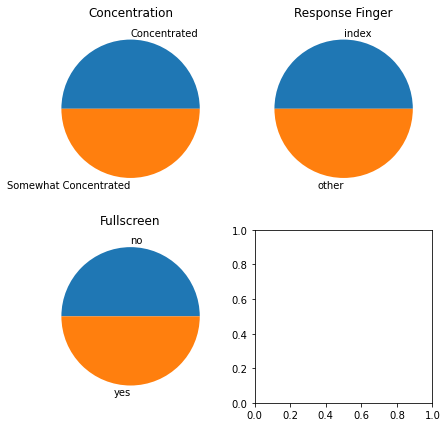

In [9]:
# check survey
# plot the distribution of responses in pie charts
def get_pie_parts(data_series):
    
    full_length = len(data_series)
    parts = []
    names = np.unique(data_series)
    
    for name in names:
        parts.append(sum(data_series == name))
    parts = np.array(parts)/full_length
    
    return parts, names
fig, axs = plt.subplots(2,2, figsize = (7,7))
axs[0,0].set_title('Concentration')
parts_concentration, names_concentration = get_pie_parts(sdf[sdf.test_part == 'outro_concentration'].survey_response)
axs[0,0].pie(parts_concentration, labels = names_concentration);

axs[0,1].set_title('Response Finger')
parts_finger, names_finger = get_pie_parts(sdf[sdf.test_part == 'outro_finger'].survey_response)
axs[0,1].pie(parts_finger, labels = names_finger);

axs[1,0].set_title('Fullscreen')
parts_screen, names_screen = get_pie_parts(sdf[sdf.test_part == 'outro_screen'].survey_response)
axs[1,0].pie(parts_screen, labels = names_screen);

print('comments: ')
print(np.unique(sdf[sdf.test_part == 'outro_comments'].survey_response))

In [21]:
s_data.columns

Index(['subject', 'trialID', 'touchX', 'touchY', 'button-x', 'button-y',
       'jump-x', 'jump-y', 'tDur', 'startTime', 'endTime', 'waitTime',
       'flashTime', 'flashOnTime', 'flashOffTime', 'touchOn', 'touchOff',
       'allTouches'],
      dtype='object')

In [19]:
jumpColumns = ['subject','trialID', 'rt', 'mt', 'tDur', 'cTouchX', 'cTouchY','sTouchX', 'sTouchY', 
               'startTime', 'endTime', 'goSignalTime', 'goTime', 'waitTime',
               'sideX','sideY', 'centralX', 'centralY', 'jumpedX', 'jumpedY', 'docTouches',
               'position', 'stimJumped', 'flashShown', 'inwards', 
               'fixTime', 'flashTime', 'trialDuration', 'flashOnTime', 'flashOffTime', 'respTime']

j_data = j_data[jumpColumns]

serialColumns = ['subject','trialID', 'touchX', 'touchY', 'button-x', 'button-y', 'jump-x', 'jump-y', 
                 'tDur', 'startTime', 'endTime', 'waitTime', 'flashTime',  
                 'flashOnTime', 'flashOffTime','touchOn', 'touchOff', 'allTouches']

s_data = s_data[serialColumns]

# compute the onset relative to the start
def relate_to_onset(data, cols, startcol):
    
    """
    Function that align the columns relative to one particular event
    
    INPUT:
    data: a pandas data frame that holds the relevant columns
    cols: a list of all column names that should be aligned
    startcol: the name of the column that serves as onset value
    
    OUTPUT
    The aligned data frame, with an extra column "sync" where the start values are saved.

    """
   
    # save the start column values in the first variable
    data.loc[:]['sync'] = data[startcol]
    
    # loop through all columns
    for col in cols:
        
        try: 
            # subtract the value of the start column
            data.loc[:][col] = data[col]-data[startcol]
            
        except TypeError:
            # if the column holds a list, use list comprehension to extract the values
            data.loc[:][col] = [np.array(data[col][x]) - data[startcol][x] for x in data.index]
    
    return data

# define the columns that contain timing information
jump_timing = ['startTime', 'endTime', 'goTime','fixTime', 'flashOnTime', 'flashOffTime', 'respTime']
# apply alignment to jump data
df_jump = relate_to_onset(j_data.copy(), jump_timing, 'goSignalTime')

# add one column that indicates the onset relative to the flash
df_jump['goAfterFlashTime'] = df_jump['goTime'] - df_jump['flashOnTime']

# repeat for serial data
serial_timing = ['endTime', 'waitTime', 'flashOnTime', 'flashOffTime','touchOn', 'touchOff']
df_serial = relate_to_onset(s_data.copy(), serial_timing, 'startTime')
# reverse the order of buttons
for x in df_serial.index:
    df_serial['button-x'][x].reverse()
    df_serial['button-y'][x].reverse()    

In [20]:
df_jump.columns

Index(['subject', 'trialID', 'rt', 'mt', 'tDur', 'cTouchX', 'cTouchY',
       'sTouchX', 'sTouchY', 'startTime', 'endTime', 'goSignalTime', 'goTime',
       'waitTime', 'sideX', 'sideY', 'centralX', 'centralY', 'jumpedX',
       'jumpedY', 'docTouches', 'position', 'stimJumped', 'flashShown',
       'inwards', 'fixTime', 'flashTime', 'trialDuration', 'flashOnTime',
       'flashOffTime', 'respTime', 'goAfterFlashTime'],
      dtype='object')

Jump coefficient: [[0.10072516]]
Stay coefficient: [[-0.01360253]]


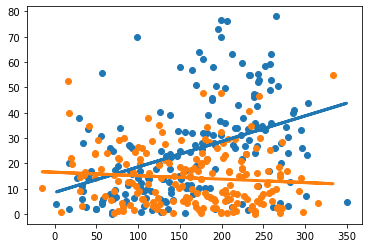

In [22]:
# Check data quality jump:
# error response - jumped target decreases with time

# filter for jumped trials
df_jump_true = df_jump[df_jump.stimJumped == 1.0]
df_jump_false = df_jump[df_jump.stimJumped == 0.0]

# error: 
x_error_jump = df_jump_true.sideX - df_jump_true.sTouchX
x_error_stay = df_jump_false.sideX - df_jump_false.sTouchX


# distance from mean error 
x_error_jump = abs(x_error_jump - np.mean(x_error_jump))
x_error_stay = abs(x_error_stay - np.mean(x_error_stay))


# time
soa_jump = df_jump_true.goTime - df_jump_true.flashTime
soa_stay = df_jump_false.goTime - df_jump_false.flashTime


# 1. plot
plt.scatter(soa_jump, x_error_jump)
plt.scatter(soa_stay, x_error_stay)


# 2. linear regression
regr_jump = linear_model.LinearRegression()
regr_jump.fit(soa_jump.values.reshape(-1,1), x_error_jump.values.reshape(-1,1))

regr_stay = linear_model.LinearRegression()
regr_stay.fit(soa_stay.values.reshape(-1,1), x_error_stay.values.reshape(-1,1))

x_error_jump_pred = regr_jump.predict(soa_jump.values.reshape(-1,1))
x_error_stay_pred = regr_stay.predict(soa_stay.values.reshape(-1,1))


print('Jump coefficient: {}'.format(regr_jump.coef_))
print('Stay coefficient: {}'.format(regr_stay.coef_))

plt.plot(soa_jump, x_error_jump_pred, linewidth = 3);
plt.plot(soa_stay, x_error_stay_pred, linewidth = 3);


In [24]:
# transform the serial data set to one column for each button touch

# initialize lists fro the columns
X_touch_colnames = [] 
Y_touch_colnames = []
X_target_colnames = []
Y_target_colnames = []
time_colnames = []
lift_colnames = []

# for all targets that will be touched
for tar in range(0,6):
    
    timeOn_name = 'touchOnTime_tar{}'.format(tar)
    x_touch_name  = 'touchX_tar{}'.format(tar)
    y_touch_name  = 'touchY_tar{}'.format(tar)
    x_target_name = 'targetX_tar{}'.format(tar)
    y_target_name = 'targetY_tar{}'.format(tar)
    
    # add these names to their lists 
    X_touch_colnames.append(x_touch_name)
    Y_touch_colnames.append(y_touch_name)
    X_target_colnames.append(x_target_name)
    Y_target_colnames.append(y_target_name)
    time_colnames.append(timeOn_name)
    
    # extract lists of each
    timeOn_tar = [df_serial.touchOn[x][tar] for x in df_serial.index]
    X_touch = [df_serial.touchX[x][tar] for x in df_serial.index] 
    Y_touch = [df_serial.touchY[x][tar] for x in df_serial.index] 
    X_target = [df_serial['button-x'][x][tar] for x in df_serial.index] 
    Y_target = [df_serial['button-y'][x][tar] for x in df_serial.index] 
    
    
    # save in df
    df_serial[timeOn_name] = timeOn_tar
    df_serial[x_touch_name] = X_touch
    df_serial[y_touch_name] = Y_touch
    df_serial[x_target_name] = X_target
    df_serial[y_target_name] = Y_target
    
    # lift times will be tracked for the first 5 lifts
    
    if tar < 5:
        timeOff_name = 'touchOff_time_{}'.format(tar)
        lift_colnames.append(timeOff_name)
        
        timeOff_tar = [df_serial.touchOff[x][tar] for x in df_serial.index]
        
        df_serial[timeOff_name] = timeOff_tar
    
# show df
df_serial[lift_colnames]

,touchOff_time_0,touchOff_time_1,touchOff_time_2,touchOff_time_3,touchOff_time_4
1072,73.0,273.0,449.0,639.0,825.0
1075,58.0,236.0,423.0,579.0,954.0
1078,57.0,242.0,416.0,608.0,792.0
1081,55.0,232.0,423.0,607.0,782.0
1084,39.0,230.0,414.0,595.0,781.0
...,...,...,...,...,...
3557,67.0,248.0,447.0,599.0,761.0
3568,32.0,215.0,388.0,579.0,756.0
3594,70.0,260.0,412.0,577.0,740.0
3602,53.0,224.0,407.0,601.0,796.0


In [37]:
# Sanity check: the y touch is correlated with the y position of each dot. 

# step 1: only data without a step
np.where(s_data['button-x'] == s_data['jump-x'])

(array([], dtype=int64),)

In [ ]:
# Question: why are the first targets more off - because of the jump?

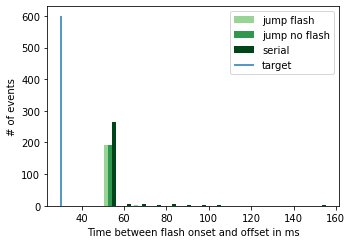

In [25]:
# some sanity checks

# check one: 
# variance between flash on and off

# get color map
cmap_flashDur = plt.cm.Greens(np.linspace(0.4,1,3))

# create plot
figFlash, axsFlash = plt.subplots(1,1, figsize = (5,3.5))
axsFlash.hist([df_jump[df_jump.flashShown == 1.0].flashOffTime - df_jump[df_jump.flashShown == 1.0].flashOnTime, df_jump[df_jump.flashShown == 0.0].flashOffTime - df_jump[df_jump.flashShown == 0.0].flashOnTime, df_serial.flashOffTime - df_serial.flashOnTime], color = cmap_flashDur, bins = 15, label = ['jump flash', 'jump no flash', 'serial']);
axsFlash.vlines(30, 0, 600, label = 'target');

axsFlash.legend()
axsFlash.set_xlabel('Time between flash onset and offset in ms')
axsFlash.set_ylabel('# of events')

plt.tight_layout()



### QUESTION 
by Richard Schweitzer

What screen refresh rate generates this pattern?

In [ ]:
# clean the data and plot again

clean_jump = df_jump[df_jump['flashOffTime'] - df_jump['flashOnTime'] <= 36]
clean_serial = df_serial[df_serial['flashOffTime'] - df_serial['flashOnTime'] <= 36]

# create figure
figFlashClean, axsFlashClean = plt.subplots(1,1, figsize = (5,3.5))
axsFlashClean.hist([clean_jump[clean_jump.flashShown == 1.0].flashOffTime - clean_jump[clean_jump.flashShown == 1.0].flashOnTime, clean_jump[clean_jump.flashShown == 0.0].flashOffTime - clean_jump[clean_jump.flashShown == 0.0].flashOnTime, clean_serial.flashOffTime - clean_serial.flashOnTime], color = cmap_flashDur, bins = 15, label = ['jump flash', 'jump no flash', 'serial']);
#axsFlashClean.vlines(30, 0, 600, label = 'target');

axsFlashClean.legend()
axsFlashClean.set_xlabel('Time between flash onset and offset in ms')
axsFlashClean.set_ylabel('# of events')


plt.tight_layout()

plt.savefig('../figures/flashdurationsclean.png')

The flash never happens too early, and sometimes happens a little too late (mostly one refresh).
There is no systematic variance in the delay between the trails.

In [ ]:
# check two: 
# do the reaction times look reasonable?

figRTs, axsRTs = plt.subplots(1,1, figsize = (5, 3.5), sharex = True, sharey = True)
cmap_respTime = plt.cm.Greens(np.linspace(0.4, 1, 2))

axsRTs.hist([df_jump.goTime, df_serial.touchOnTime_tar1], label = ['jump', 'serial'], color = cmap_respTime)

#axs1[1].hist([df_jump[df_jump.flashShown == 1.0].rt, df_jump[df_jump.flashShown == 0.0].rt], label = ['online FLASH', 'online NOFLASH']);
axsRTs.legend()
axsRTs.set_xlabel('Reaction time in ms')
axsRTs.set_ylabel('# of events')

plt.savefig('../figures/reactiontimes.png')

#axs1[1].legend();


### TODO: 
Plot the response times for all later points, too

In [ ]:
# check three: 
# what was the distribution of flash onsets across the trial?

plt.hist([df_jump[df_jump.flashShown == 1.0].flashOnTime, df_jump[df_jump.flashShown == 0.0].flashOnTime], label = ['jump FLASH', 'jump NOFLASH']);
plt.legend();

In [ ]:
# check four: 
# what was the distribution hand movement onsets relative to the flash?

plt.hist([df_jump[df_jump.flashShown == 1.0].goAfterFlashTime, df_jump[df_jump.flashShown == 0.0].goAfterFlashTime], label = ['jump FLASH', 'jump NOFLASH'], bins = 20);
plt.legend();

Note to myself: make the delay longer!

In [ ]:
# make a timeline
# columns we want to plot:
t_times = ['startTime', 'flashOnTime', 'flashOffTime']
t_actions = ['goTime'] 

# define a colormap
t_cm = plt.cm.viridis_r(np.linspace(0,1,len(t_times)))
time_fig, time_ax = plt.subplots(1,1, figsize = (14,4))

# loop through relevant times
for tim, c in zip(t_times, t_cm):
    # get and plot the mean
    mean_val = np.mean(df_jump[tim])
    time_ax.vlines(mean_val, 0, 5, color = c, label = tim, alpha = 0.5)

a_cm = plt.cm.jet(np.linspace(0,1,len(t_actions)))

# and timed actions
for ac, c in zip(t_actions, a_cm):
    # get and plot the mean
    mean_val = np.mean(df_jump[ac])
    time_ax.vlines(mean_val, 0, 5, color = c, label = ac, alpha = 0.5)
        
        
time_ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');




In [ ]:
# same timeline for serial task
#create colormap
t_cm = plt.cm.viridis_r(np.linspace(0,1,len(time_colnames)))
time_fig2, time_ax2 = plt.subplots(1,1, figsize = (14,4))

# loop through all timed events
for tim, c in zip(time_colnames, t_cm):
    # get and plot mean
    mean_val = np.mean(df_serial[tim])
    time_ax2.vlines(mean_val, 0, 5, color = c, label = tim, alpha = 0.5)
    
time_ax2.vlines(np.mean(df_serial.flashOnTime), 0, 5, label = 'flash On')
time_ax2.vlines(np.mean(df_serial.flashOffTime), 0, 5, label = 'flash Off')

time_ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

In [ ]:
# plot the x and y touches and lifts

plt.scatter(df_jump.cTouchX, df_jump.cTouchY, label = 'central')
plt.scatter(df_jump.sTouchX, df_jump.sTouchY, label = 'side')

# add the central points from meta data
plt.scatter(mdf.CenterX, mdf.CenterY, label = 'screenCenter')

# add description
plt.xlabel('size in px (1px = 0.026 cm)')

plt.legend();

In [ ]:
# center the x/y coordinates relative to the screen center
# for jump trials

# initialize column names
df_jump['cNormX'] = np.nan
df_jump['cNormY'] = np.nan
df_jump['sNormX'] = np.nan
df_jump['sNormY'] = np.nan

# get the data from each subject
for subject in np.unique(df_jump.subject):
    
    subjectOn = df_jump.subject == subject
    
    # get the mean of the first touches
    meanX = np.mean(df_jump[df_jump.subject == subject]['cTouchX'])
    meanY = np.mean(df_jump[df_jump.subject == subject]['cTouchY'])
    
    # subtract the mean value from the other values
    df_jump.loc[subjectOn, 'cNormX'] = df_jump[subjectOn]['cTouchX']-meanX
    df_jump.loc[subjectOn, 'cNormY'] = df_jump[subjectOn]['cTouchY']-meanY
    
    df_jump.loc[subjectOn, 'sNormX'] = df_jump[subjectOn]['sTouchX'] - meanX
    df_jump.loc[subjectOn, 'sNormY'] = df_jump[subjectOn]['sTouchY'] - meanY

In [ ]:
plt.scatter(df_jump.cNormX, df_jump.cNormY)
plt.scatter(df_jump.sNormX, df_jump.sNormY)

In [ ]:
# Same thing for serial trials

# for all targets that will be touched
t_cm = plt.cm.viridis_r(np.linspace(0,1,len(time_colnames)))

for tarX, tarY, c in zip(X_colnames,Y_colnames, t_cm):
    
    # plot
    plt.scatter(df_serial[tarX], df_serial[tarY], color = c)
    
# add screen center

plt.scatter(mdf.CenterX, mdf.CenterY, label = 'screenCenter', color = 'orange', s = 100)
plt.scatter(df_serial['button0-x'], df_serial['button0-y'], label = 'button 0', color = 'white', s = 100)

In [ ]:
# center relative to the first dot 
# for serial trials

# get the unique locations of the y button
for yLoc in np.unique(df_serial['button0-y']):
    
    # filter the data according to this values
    yLocOn = df_serial['button0-y'] == yLoc
    
    # get the mean value of this touch in the filtered data
    meanX = np.mean(df_serial[df_serial['button0-y'] == yLoc][X_colnames[0]])
    meanY = np.mean(df_serial[df_serial['button0-y'] == yLoc][Y_colnames[0]])
    
    # loop through all columns and center them around this mean
    for Xcol, Ycol in zip(X_colnames, Y_colnames):
        
        df_serial.loc[yLocOn, Xcol] = df_serial[yLocOn][Xcol]-meanX
        df_serial.loc[yLocOn, Ycol] = df_serial[yLocOn][Ycol]-meanY

In [ ]:
# Same thing for serial trials

# for all targets that will be touched
t_cm = plt.cm.Blues(np.linspace(0.2,1,len(time_colnames)))
# create a figure
figResp, axsResp = plt.subplots(2,1, figsize = (7,7), sharey = True) 

# go through all columns
for tarX, tarY, c in zip(X_colnames,Y_colnames, t_cm):
    # set different alpha levels for each subject
    for subject, alpha in zip(np.unique(df_serial.subject), np.linspace(0.5,1, len(np.unique(df_serial.subject)))):
    
        # plot
        axsResp[0].scatter(df_serial[df_serial.subject == subject][tarX], df_serial[df_serial.subject == subject][tarY], color = c, alpha = alpha)
# label
axsResp[0].set_xlabel('X-distance from first touch in px')
axsResp[0].set_ylabel('Y-distance from first touch in px')
axsResp[0].set_title('Responses in the Serial Paradigm')

axsResp[1].set_xlabel('X-distance from first touch in px')
axsResp[1].set_ylabel('Y-distance from first touch in px')
axsResp[1].set_title('Responses in the Jump Paradigm');

plt.tight_layout();

In [ ]:
# clean xy coordinate that are not centered around 0
# for both tasks

df_jump.drop(df_jump[abs(df_jump.cNormX)>100].index, inplace = True)
df_jump.drop(df_jump[abs(df_jump.cNormY)>100].index, inplace = True)
df_jump.drop(df_jump[abs(df_jump.sNormY)>100].index, inplace = True)


In [ ]:
# set new colormap for jump responses
points_cm = plt.cm.Blues(np.linspace(0.2,1,4))

# plot all locations
axsResp[1].scatter(df_jump.cNormX, df_jump.cNormY, color = points_cm[0])
axsResp[1].scatter(df_jump[df_jump.stimJumped==False].sNormX, df_jump[df_jump.stimJumped==False].sNormY, color = points_cm[1])

axsResp[1].scatter(df_jump[(df_jump.stimJumped==True) & (df_jump.inwards == True)].sNormX, df_jump[(df_jump.stimJumped==True)  & (df_jump.inwards == True)].sNormY, color = points_cm[2])
axsResp[1].scatter(df_jump[(df_jump.stimJumped==True) & (df_jump.inwards == False)].sNormX, df_jump[(df_jump.stimJumped==True)  & (df_jump.inwards == False)].sNormY, color = points_cm[3])

plt.tight_layout();

In [ ]:
# save the touch response figure
figResp
figResp.savefig('../figures/touchlocations.png')


In [ ]:
figResp

In [ ]:
# look for dips in the movement rate

figRTs, axsRTs = plt.subplots(3,1, figsize = (15, 5), sharex = True, sharey = True)

df_flash = df_serial[np.isnan(df_serial.flashOnTime) == False]

# plot reaction time distributions relative to regular onset

regRTs = [df_flash[x] for x in time_colnames]
axsRTs[0].hist(regRTs, bins = 25, color = t_cm);

# plot reaction time distribution relative to random values
np.random.seed(1111)
randT = np.random.sample(len(df_flash.index))
randT = randT * 1000
df_flash['randFlashOn'] = randT 

randRTs = [df_flash[x] - randT for x in time_colnames]
axsRTs[1].hist(randRTs, bins = 25, color = t_cm);

# plot reaction time distributions relative to flash onset
flashRTs = [df_flash[x] - df_flash.flashOnTime for x in time_colnames]
axsRTs[2].hist(flashRTs, bins = 25, color = t_cm);


The quality control till here looks good. We need to add a few more questions to the participants (about the device) and need to correct the code that reads out the X and Y coordinates of stimuli on the screen.

Also, we might want to present the flash over a longer time, not only 250 ms

In [ ]:
# martin's serial inhibition code

def causRate(msOns, wbLock, waLock, nt):
    """

     analyse rate in causal time window

     input:    msOns   - microsaccade onset times
               wbLock  - window before lock
               waLock  - window after lock
               nt      - number of trials
    
     output:   rate    - microsaccade rate
               scale   - time axis
    
    12.12.2005 by Martin Rolfs
    21.06.2021 translated to python by Clara Kuper
    """
    
    # check how many trials these values came from
    if type(nt)==int:
        nt = np.linspace(nt,nt,len(np.arange(-wbLock,waLock, 1)));
    elif len(nt)!=len(np.arange(-wbLock,waLock, 1)):
        error('nt must have the same length as -wbLock:waLock!')

    # alpha defines how much the distribution is shifted
    alpha = 1/20;
    # define empty arrays for scale and rate
    scale = [];
    rate = [];
    
    # loop through all time windows
    for t in np.arange(-wbLock,waLock):
        
        # save the time
        scale.append(t)
        # compute tau
        tau = t-msOns+1/alpha
        # filter tau as event 0/1
        tau = tau[tau>0]
        # get the number of saccades in a given window
        causal = alpha**2*tau*np.exp(-alpha*tau)
        # save the rate 
        rate.append(sum(causal)*1000/nt[len(scale)-1])
    
    return rate, scale

### UNDERSTANDING PROBLEM
Please define: what is this code doing?

In [ ]:
def plot_means_std(rates, scales, ax, cmap, labels):
    
    """
    plot the mean value and standart errors around
    
    INPUT: 
    rates: the values on which error and mean are computed (an array of arrays!)
    scales: the x value against which they are plotted (an array of arrays!)
    ax: the figure axis on which we plot
    cmap: the color scheme to be used
    labels: the labels for the legend
    """
    
    # zip and loop through the arrays
    for rate, scale, c, l in zip(rates,scales, cmap, labels):
        
        # compute mean
        mu = np.array(rate, dtype = np.float64).mean(axis=0)
        # compute error
        sigma = np.array(rate, dtype = np.float64).std(axis=0)
        # plot mean
        ax.plot(scale, mu, lw=1, color = c, label = l)
        # plot error
        ax.fill_between(scale, mu+sigma, mu-sigma, color = c, alpha = 0.5)

In [ ]:
# compute and plot saccade rates
rates_onset = []
rates_random = []
rates_flash = []

for s in subjects:
    
    df_s = df_flash[df_flash.subject == s]
    
    # aligned to the original 0
    serial_onsets_start = [df_s[x].values for x in time_colnames]
    serial_onsets_start = np.array(serial_onsets_start).flatten()
    serial_start, scale_start = causRate(serial_onsets_start, 0, 1000, len(df_s.index))

    # aligned to a random onset
    serial_onsets_random = [df_s[x].values - df_s['randFlashOn'].values for x in time_colnames]
    serial_onsets_random = np.array(serial_onsets_random).flatten()
    serial_random, scale_random = causRate(serial_onsets_random, 1000, 1000, len(df_s.index))

    # aligned to flash onset
    serial_onsets_flash = [df_s[x].values - df_s['flashOnTime'].values for x in time_colnames]
    serial_onsets_flash = np.array(serial_onsets_flash).flatten()
    serial_flash, scale_flash = causRate(serial_onsets_flash, 1000, 1000, len(df_s.index))

    # put all subjects in one list
    rates_onset.append(serial_start)
    rates_random.append(serial_random)
    rates_flash.append(serial_flash)

    
# initialize figure    
figRate, axsRate = plt.subplots(2,1, figsize = (7, 5))
cmap_flashOnOff = shiftcmp(np.linspace(0.1,0.8,2))

# plot on the figure
plot_means_std([rates_onset], [scale_start], axsRate[0], plt.cm.Blues(np.linspace(0.8,0.9,1)), ['from onset'])
plot_means_std([rates_flash, rates_random], [scale_random, scale_flash], axsRate[1], cmap_flashOnOff, ['flash', 'random'])

# add titles and stuff
axsRate[0].set_title('Touch responses after onset')
axsRate[1].set_title('Touch responses after flash')


axsRate[0].set_xlabel('Time after first touch in ms')
axsRate[1].set_xlabel('Time after flash in ms')

axsRate[0].set_ylabel('Movement onset rate')
axsRate[1].set_ylabel('Movement onset rate')


axsRate[1].legend()

plt.tight_layout()

plt.savefig('../figures/responseratesserial.png')

In [ ]:
# make a larger zoom window
figZoom, axsZoom = plt.subplots(1,1, figsize = (7, 3.5))

plot_means_std([[fr[1000:1200] for fr in rates_flash], [rr[1000:1200] for rr in rates_random]], [scale_random[1000:1200], scale_flash[1000:1200]], axsZoom, cmap_flashOnOff, ['flash', 'random'])
axsZoom.set_title('Zoom on responses after flash')
axsZoom.set_xlabel('Time after flash in ms')

plt.tight_layout()
plt.savefig('../figures/zoomedresponserates.png')


In [ ]:
# same analysis for liftts rather than touches
# aligned to the original 0
serial_offsets_start = [df_flash[x].values for x in lift_colnames]
serial_offsets_start = np.array(serial_onsets_start).flatten()
serialoff_start, scaleoff_start = causRate(serial_onsets_start, 0, 1000, len(df_flash.index)*5)

# aligned to a random onset
serial_offsets_random = [df_flash[x].values - df_flash['randFlashOn'].values for x in lift_colnames]
serial_offsets_random = np.array(serial_onsets_random).flatten()
serialoff_random, scaleoff_random = causRate(serial_onsets_random, 1000, 1000, len(df_flash.index)*5)

# aligned to flash onset
serial_offsets_flash = [df_flash[x].values - df_flash['flashOnTime'].values for x in lift_colnames]
serial_offsets_flash = np.array(serial_onsets_flash).flatten()
serialoff_flash, scaleoff_flash = causRate(serial_onsets_flash, 1000, 1000, len(df_flash.index)*5)


figRate, axsRate = plt.subplots(2,1)
axsRate[0].plot(scaleoff_start, serialoff_start)
axsRate[1].plot(scaleoff_random, serialoff_random, label = 'random')
axsRate[1].plot(scaleoff_flash, serialoff_flash, label = 'flash')

axsRate[1].legend();

In [ ]:
# same rate analysis for jump trials

# compute and plot saccade rates

# aligned to the original 0
rate_start_jump, scale_start_jump = causRate(df_jump.goTime, 0, 500, len(df_jump.index)*5)

# aligned to a random onset
rate_random_jump, scale_random_jump = causRate(df_jump[df_jump.flashShown == False].goTime - df_jump[df_jump.flashShown == False].flashOnTime, 500, 500, len(df_jump[df_jump.flashShown == True].index)*5)

# aligned to flash onset
rate_flash_jump, scale_flash_jump = causRate(df_jump[df_jump.flashShown == True].goTime - df_jump[df_jump.flashShown == True].flashOnTime, 500, 500, len(df_jump[df_jump.flashShown == True].index)*5)

# plot
figRateJump, axsRateJump = plt.subplots(2,1)
axsRateJump[0].plot(scale_start_jump, rate_start_jump, color = points_cm[3])
axsRateJump[1].plot(scale_random_jump, rate_random_jump, label = 'random', color = points_cm[1])
axsRateJump[1].plot(scale_flash_jump, rate_flash_jump, label = 'flash', color = points_cm[0])

axsRateJump[1].legend();

In [ ]:
# finer analysis of the plot above: split by condition (jump or not)

df_jumpFlash = df_jump[df_jump.flashShown == True]
df_jumpNoFlash = df_jump[df_jump.flashShown == False]

# aligned to NoFlash
rate_noflashshift_jump, scale_noflashshift_jump = causRate(df_jumpNoFlash[df_jumpNoFlash.stimJumped == True].goTime - df_jumpNoFlash[df_jumpNoFlash.stimJumped == True].flashOnTime, 0, 500, len(df_jumpNoFlash[df_jumpNoFlash.stimJumped == True].index)*5)
rate_noflashnoshift_jump, scale_noflashnoshift_jump = causRate(df_jumpNoFlash[df_jumpNoFlash.stimJumped == False].goTime - df_jumpNoFlash[df_jumpNoFlash.stimJumped == False].flashOnTime, 0, 500, len(df_jumpNoFlash[df_jumpNoFlash.stimJumped == False].index)*5)

# aligned to Flash
rate_flashshift_jump, scale_flashshift_jump = causRate(df_jumpFlash[df_jumpFlash.stimJumped == True].goTime - df_jumpFlash[df_jumpFlash.stimJumped == True].flashOnTime, 0, 500, len(df_jumpFlash[df_jumpFlash.stimJumped == True].index)*5)
rate_flashnoshift_jump, scale_flashnoshift_jump = causRate(df_jumpFlash[df_jumpFlash.stimJumped == False].goTime - df_jumpFlash[df_jumpFlash.stimJumped == False].flashOnTime, 0, 500, len(df_jumpFlash[df_jumpFlash.stimJumped == False].index)*5)

# plot
figRateShifts, axsRateShifts = plt.subplots(2,1, sharex = True, sharey = True)
axsRateShifts[0].plot(scale_noflashshift_jump, rate_noflashshift_jump, label = 'shift', color = points_cm[3])
axsRateShifts[0].plot(scale_noflashnoshift_jump, rate_noflashnoshift_jump, label = 'no shift', color = points_cm[2])
                                                           
axsRateShifts[1].plot(scale_flashshift_jump, rate_flashshift_jump, label = 'shift', color = points_cm[0])
axsRateShifts[1].plot(scale_flashnoshift_jump, rate_flashnoshift_jump, label = 'no shift', color = points_cm[1])

axsRateShifts[0].legend();
axsRateShifts[1].legend();

In [ ]:
def get_rate_cond(data, std_by, condition_col, time_col):
    
    """
    extracts the causal rate for conditions that are true or false
    
    INPUT:
    data: the data frame from where the condition is extracted
    std_by: the column that tells us across which dimension we compute standart errors
    condition_col: the condition that should be true or fals
    time_col: the column that contains the actual value from where we want to extract rates
    
    
    OUTPUT: a list of rates and scales for true and false values
    """
    
    # initialize arrays
    cond_true = []
    cond_false = []
    
    # get the unique values of the dimension used for std
    by_param = np.unique(data[std_by])
    
    # loop through all the istances used for averaging
    for param in by_param:
        
        # extract the data
        df_p = data[data[std_by] == param]
        # filter the df according to the condition
        df_true = df_p[df_p[condition_col] == True]
        df_false = df_p[df_p[condition_col] == False]
        
        # get the rate and the scales
        rate_true, scale_true = causRate(df_true[time_col], 0, 500, len(df_true.index))
        rate_false, scale_false = causRate(df_false[time_col], 0, 500, len(df_false.index))
        
        # collect the rates in one list
        cond_true.append(rate_true)
        cond_false.append(rate_false)
        
    return cond_true, cond_false, scale_true, scale_false
        

# flash/no flash -> differences & subject interval
flash_rate, noflash_rate, flash_scale, noflash_scale = get_rate_cond(df_jump, 'subject', 'flashShown', 'goAfterFlashTime')

# shift/no shift -> differences & subject interval
shift_rate, noshift_rate, shift_scale, noshift_scale = get_rate_cond(df_jump, 'subject', 'stimJumped', 'goAfterFlashTime')


fig, ax = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)
cmap_flashOnOff = shiftcmp(np.linspace(0.1,0.8,2))
cmap_shiftOnOff = plt.cm.RdGy(np.linspace(0.1,0.7,2))
plot_means_std([flash_rate, noflash_rate], [flash_scale, noflash_scale], ax[0], cmap_flashOnOff, ['flash', 'no flash'])
plot_means_std([shift_rate, noshift_rate], [shift_scale, noshift_scale], ax[1], cmap_shiftOnOff, ['shift', 'no shift'])

ax[0].legend()
ax[1].legend()

ax[0].set_title('Effect of flash onset')
ax[1].set_title('Effect of target shift')

ax[0].set_xlabel('Time since flash in ms')
ax[1].set_xlabel('Time since flash in ms')

ax[0].set_ylabel('Movement onset rate')

plt.tight_layout()
plt.savefig('../figures/responseratesjump.png')

In [ ]:
# single figures of the flash/noflash contrast above for illustration
figSolo, axsSolo = plt.subplots(1,2, figsize = (5,2.5))
plot_means_std([flash_rate], [flash_scale], axsSolo[0], cmap_flashOnOff, ['flash', 'no flash'])
plot_means_std([noflash_rate], [noflash_scale], axsSolo[1], shiftcmp(np.linspace(0.8,0.8,1)), ['flash', 'no flash'])

axsSolo[0].set_title('flash')
axsSolo[1].set_title('no flash')

axsSolo[0].set_ylabel('movement rate')
axsSolo[1].set_ylabel('movement rate')

axsSolo[0].set_xlabel('time in ms')
axsSolo[1].set_ylabel('time in ms')


plt.tight_layout()
plt.savefig('../figures/individualflash.png')

In [ ]:
# compute the interaction of shift/noshift in flash and no flash trials
flash_df = df_jump[df_jump.flashShown == True]
noflash_df = df_jump[df_jump.flashShown == False]

# get the rates and scales
flash_shift_rate, flash_noshift_rate, flash_shift_scale, flash_noshift_scale = get_rate_cond(flash_df, 'subject', 'stimJumped', 'goAfterFlashTime')
noflash_shift_rate, noflash_noshift_rate, noflash_shift_scale, noflash_noshift_scale = get_rate_cond(noflash_df, 'subject', 'stimJumped', 'goAfterFlashTime')

# create the figure
fig2, ax2 = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)

# plot with std
plot_means_std([flash_shift_rate, flash_noshift_rate], [flash_shift_scale, flash_noshift_scale], ax2[0], cmap_shiftOnOff, ['shift', 'no shift'])
plot_means_std([noflash_shift_rate, noflash_noshift_rate], [noflash_shift_scale, noflash_noshift_scale], ax2[1], cmap_shiftOnOff, ['shift', 'no shift'])

ax2[0].legend()
ax2[1].legend()
ax2[0].set_title('Flash Present')
ax2[1].set_title('Flash Absent')

ax2[0].set_xlabel('Time since flash in ms')
ax2[1].set_xlabel('Time since flash in ms')

ax2[0].set_ylabel('Movement onset rate')

plt.tight_layout()
plt.savefig('../figures/responseratesinteractionjump.png')


### COMMENT 
by Martin Rolfs:

would make sense if the movements were initiated faster after a shift & flash: the flash facilitates the reaction to behaviorally relevant stimuli

In [ ]:
# visualize dependence soa/error to new target
# extract the error size 
# assign the distance of the target relative to the center. This assignment step is necessary now, 
# because the readout from the experiment didn't work. But it will not be necessary in later versions
# initilize the column
df_jump['targetXPos'] = np.nan

# define the condition - jump or not
for s in np.unique(df_jump.stimJumped):
    # inwards or outwards shift
    for d in np.unique(df_jump.inwards):
        # left or right
        # get the indeces
        idx = df_jump[(df_jump.stimJumped == s) & (df_jump.inwards == d)].index
        # this is the standart target position
        tar = 200
        # the position differs when there was a shift
        if s == 1.0:
            # the shift was either 50 px inwards or outwards
            if d == 1.0:
                tar -= 50
            else:
                tar += 50

        # save the values to the df
        df_jump.loc[idx, 'targetXPos'] = tar
        
# the error ist the distance between the actual target and the touch response
df_jump['sErrorX'] = abs(df_jump['sNormX']) - df_jump['targetXPos']
            
# same assignment to the serial task
# the distance of individual dots
pointDist = 80

# go through all targets

error_colnames = []

for col in range(0,6):
    
    # initialize column names
    colname_error = 'xError_tar{}'.format(col)
    error_colnames.append(colname_error)
    colname_response = X_colnames[col]
    # substract the position of the dot from the response
    df_flash[colname_error] = df_flash[colname_response] - (col * pointDist)

In [ ]:
# check the distribution of X errors in the jump task
plt.hist(df_jump.sErrorX);

In [ ]:
targetErrors = [df_flash[x] for x in error_colnames]

# check the distribution of x errors in the serial task
plt.hist(targetErrors, label = ['0','1', '2', '3', '4', '5'])
plt.legend();

In [ ]:
def moving_window_mean(time_series, data, stepsize, average_over = False, use_absolute = False, on = 1000, off = 1000):
    
    """
    exctract the mean values for each window in a moving mean 
    
    INPUT:
    time_series: the timepoints when sth occures
    data: the data points to be averaged, same temporal order as the time_series
    stepsize: the size of each step
    average_over: the size of each chunk that's averaged over. defaults to the value of stepsize
    use_absolut: if the average should be computed on absolute values
    
    OUTPUT:
    data frame with time onsets and mean values
    
    """
    
    # set the size of the averaging window, if necessary
    if not average_over:
        
        average_over = stepsize
    
    elif average_over < stepsize:
        # warn if the size of the window is too small
        print('watch out, your step size does not cover a full time window.')
        
    # initialize the time array
    window_array = np.arange(-1*on, off, stepsize)
    # intialize the pd array
    mean_array = pd.DataFrame(columns = ['timewindow', 'meanvalue'], index = window_array)
    mean_array.timewindow = window_array
    # loop through all time onsets
    for w in window_array:
        
        # define a mask for the time frame
        time_mask = (time_series >= w) & (time_series < w+average_over)
        # apply the mask to the data
        data_masked = data[time_mask]
        
        # check if the mask is empty
        if not data_masked.size == 0:
            
            # get the mean value
            if use_absolute:
                mean_val =  np.mean(abs(data_masked))
            else:
                mean_val =  np.mean(data_masked)
                
            mean_array.loc[w, 'meanvalue'] = mean_val
            
        else:
            mean_array.loc[w, 'meanvalue'] = np.nan
        
    return mean_array

In [ ]:
# check if the error columns look reasonable
df_flash[error_colnames]

In [ ]:
errors_start = []
errors_flash = []
errors_random = []

start = 1000
end = 1000

for s in subjects:
    
    df_s = df_flash[df_flash.subject == s]
    
    # extract the values for serial errors and flatten them
    serial_errors = [df_s[x].values for x in error_colnames]
    serial_errors = np.array(serial_errors).flatten()
    
    onset_start = [df_s[x].values for x in time_colnames]
    onset_start = np.array(onset_start).flatten()

    # aligned to a random onset
    onset_random = [df_s[x].values - df_s['randFlashOn'].values for x in time_colnames]
    onset_random = np.array(onset_random).flatten()

    # aligned to flash onset
    onset_flash = [df_s[x].values - df_s['flashOnTime'].values for x in time_colnames]
    onset_flash = np.array(onset_flash).flatten()
        
    # compute the moving average from trial onset, relative to flash onset and to a random value
    mean_error_start = moving_window_mean(onset_start, serial_errors, 20, 100, on = start, off = end)
    mean_error_flash = moving_window_mean(onset_flash, serial_errors, 20, 100, on = start, off = end)
    mean_error_random = moving_window_mean(onset_random, serial_errors, 20, 100, on = start, off = end)
    
    errors_start.append(mean_error_start.meanvalue.values)
    errors_flash.append(mean_error_flash.meanvalue.values)
    errors_random.append(mean_error_random.meanvalue.values)
    
# plot the results
fig3, ax3 = plt.subplots(1,1, figsize = (7, 3.5))
plot_means_std([errors_flash, errors_random], [mean_error_flash.timewindow.values, mean_error_random.timewindow.values], ax3, cmap_flashOnOff, ['flash', 'no flash'])
ax3.legend()
ax3.set_title('Landing error')
ax3.set_xlabel('Time after flash in ms')
ax3.set_ylabel('Error in px')

plt.tight_layout()

plt.savefig('../figures/errorsserial.png')

In [ ]:
# in the jump trial, look at SOA - error relation

mean_error_SOA = moving_window_mean(df_jump.goTime - df_jump.flashOnTime, df_jump.sErrorX, 1, 20)
plt.plot(mean_error_SOA.timewindow, mean_error_SOA.meanvalue)
plt.xlim(-20,300);

In [ ]:
# plot the error/soa for different categories


def get_condition_means(data):
    
    """
    VERY specific function that splits my jump data set into conditions, computes a moving window mean and returns the result
    
    INPUT:
    data: the data frame to be split
    OUTPUT:
    the moving window means for split data
    """

    jdf_FSI = data[(data.flashShown == True) & (data.stimJumped == True) & (data.inwards == True)]
    jdf_FSO = data[(data.flashShown == True) & (data.stimJumped == True)  & (data.inwards == False)]

    jdf_F = data[(data.flashShown == True) & (data.stimJumped == False)]

    jdf_SI = data[(data.flashShown == False) & (data.stimJumped == True) & (data.inwards == True)]
    jdf_SO = data[(data.flashShown == False) & (data.stimJumped == True) & (data.inwards == False)]

    jdf = data[(data.flashShown == False) & (data.stimJumped == False)]

    mean_error_FSI = moving_window_mean(jdf_FSI.goAfterFlashTime, jdf_FSI.sErrorX, 20, 100, on = 0, off = 250)
    mean_error_FSO = moving_window_mean(jdf_FSO.goAfterFlashTime, jdf_FSO.sErrorX, 20, 100, on = 0, off = 250)

    mean_error_SI = moving_window_mean(jdf_SI.goAfterFlashTime, jdf_SI.sErrorX, 20, 100, on = 0, off = 250)
    mean_error_SO = moving_window_mean(jdf_SO.goAfterFlashTime, jdf_SO.sErrorX, 20, 100, on = 0, off = 250)

    mean_error_F = moving_window_mean(jdf_F.goAfterFlashTime, jdf_F.sErrorX, 20, 100, on = 0, off = 250)
    mean_error = moving_window_mean(jdf.goAfterFlashTime, jdf.sErrorX, 20, 100, on = 0, off = 250)
    
    return mean_error_FSI, mean_error_FSO, mean_error_SI, mean_error_SO, mean_error_F, mean_error

# initialize arrays for the conditions
FSI = []
FSO = []
SI = []
SO = []
F = []
N = []

# loop through all subjects
for s in subjects:
    
    # filter the data
    sdf = df_jump[df_jump.subject ==s]
    
    # get the moving mean per subject
    sFSI, sFSO, sSI, sSO, sF, sN = get_condition_means(sdf)
    
    # collect in array
    FSI.append(sFSI.meanvalue.values)
    FSO.append(sFSO.meanvalue.values)
    SI.append(sSI.meanvalue.values)
    SO.append(sSO.meanvalue.values)
    F.append(sF.meanvalue.values)
    N.append(sN.meanvalue.values)

# create figure
fig4, ax4 = plt.subplots(1,2, sharex = True, sharey = True, figsize = (7,3.5))

# create colormap
cmap_shiftInOut = plt.cm.RdGy(np.linspace(0.1,0.8,4))

# show errors on figure
plot_means_std([FSI, FSO, F], [sFSI.timewindow.values, sFSO.timewindow.values, sF.timewindow.values], ax4[0], cmap_shiftInOut, ['shiftIn', 'shiftOut', 'no shift'])
plot_means_std([SI, SO, N], [sSI.timewindow.values, sSO.timewindow.values, sN.timewindow.values], ax4[1], cmap_shiftInOut, ['shiftIn', 'shiftOut', 'no shift'])

#plot_means_std([FSO, F], [sFSO.timewindow.values, sF.timewindow.values], ax4[1,0], cmap_shiftOnOff, ['shift', 'no shift'])
#plot_means_std([SO, N], [sSO.timewindow.values, sN.timewindow.values], ax4[1,1], cmap_shiftOnOff, ['shift', 'no shift'])
ax4[0].set_title('Flash present')
ax4[1].set_title('Flash absent')

ax4[0].set_xlabel('Time after flash in ms')
ax4[1].set_xlabel('Time after flash in ms')

ax4[0].set_ylabel('Error in px')

ax4[0].legend()
ax4[1].legend()

plt.tight_layout()

plt.savefig('../figures/errorsjump.png')


### COMMENT
by Martin Rolfs: why are the error bars larger in the present condition than in the absent condition?